# 05 - Preprocessing Sanity Checks

The preprocessing of MRI images is a complex process in which things can go wrong at various steps. Thus, it is important to constantly monitor the quality of the data and to perform sanity checks that ensure that the respective preprocessing steps went as expected.

In this notebook, we will have a look at a few possibilites to perform quality control within Niype.



#### Questions

- What to do if the results are not as expected?
- How to find the right parameters?

#### Objective

- 

## Install dependencies and define sample workflow

Firstly, as always, we setup our folder structure and download the dependencies as well as a sample dataset:

In [2]:
import os

!mkdir /data
!mkdir -p /output/working_dir

!pip install nilearn
!pip install nipype

# install fsl
!sudo apt-get remove -y --purge man-db
!apt-get update
!apt-get install neurodebian-archive-keyring
!add-apt-repository "deb http://neuro.debian.net/debian bionic main contrib non-free"
!apt-get install fsl-core

fslpath="/usr/share/fsl/5.0" 
os.environ["FSLDIR"] = fslpath
os.environ["PATH"] += os.pathsep + os.path.join(fslpath, "bin")
!. ${FSLDIR}/etc/fslconf/fsl.sh
!export FSLDIR PATH

os.environ["LD_LIBRARY_PATH"] = os.environ["LD_LIBRARY_PATH"] + os.pathsep + "/usr/lib/fsl/5.0"

# set FSL default output type
from nipype.interfaces.fsl.base import FSLCommand
FSLCommand.set_default_output_type("NIFTI")

# add mni template to fsl dir
!mkdir /usr/share/fsl/5.0/data/standard
!gdown --id 1lytUR8CJkcvGIdhndoLjKCUloKl80iCG 
!unzip /content/mniatlas.zip -d /usr/share/fsl/5.0/data/standard

# download dataset
!gdown --id 1jREp9F13CGM1XF20qczKreUPdGoJP_76
!unzip /content/ds000114.zip -d /data

!flirt -version

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.6 MB 21.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.2 MB 33.7 MB/s 
     |████████████████████████████████| 130 kB 70.4 MB/s 
     |████████████████████████████████| 500 kB 95.4 MB/s 
     |████████████████████████████████| 5.1 MB 62.3 MB/s 
     |████████████████████████████████| 421 kB 78.5 MB/s 
     |████████████████████████████████| 41 kB 789 kB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  groff-base libnvidia-common-460 libpipeline1
Use 'sudo apt autoremove' to remove them.
The following packages will be REMOVED:
  man-db*
0 upgraded, 0 newly installed, 1 to remove and 32 not upgraded.
After this operatio

In [3]:
# helper function to list files of directory in a tree-like structure
def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print('{}{}'.format(subindent, f))

In [4]:
# as always, define some constants first

data_dir = "/data/ds000114/subjects"
output_dir = "/output"

test_subj = "sub-01"

Below is a simple workflow, in which we extract the brain from the anatomical image (using FSL's ```BET```) and correct the functional images for motion (using FSL's ```MCFLIRT```) after removing the first four volumns (using FSL's ```ExtractROI```). Furthermore, we will use a ```DataSink``` node to conveniently store the respective outputs (extracted brain, brain mask, mean functional image, realigned functional image, motion parameters).

In [5]:
from nipype import Workflow, Node
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.interfaces.fsl import ExtractROI, BET, MCFLIRT

## initialize workflow

wf = Workflow(base_dir="/output/working_dir", name="my_workflow")

template={"anat": f"{data_dir}/{test_subj}/ses-test/anat/{test_subj}_ses-test_T1w.nii.gz",
          "func": f"{data_dir}/{test_subj}/ses-test/func/{test_subj}_ses-test_task-covertverbgeneration_bold.nii.gz"}

## define nodes

selectfiles = Node(SelectFiles(templates = template),
                   name="selectfiles")

extract = Node(ExtractROI(t_min=4, t_size=-1),
               name="extract")

strip_skull = Node(BET(mask=True, frac=0.6),
                   name="strip_skull")

realigner = Node(MCFLIRT(mean_vol=True,
                         save_plots=True),
                 name="realigner")

datasink = Node(DataSink(base_directory="/output"),
                name="datasink")

wf.connect([ (selectfiles, strip_skull, [("anat", "in_file")]),
             (selectfiles, extract,     [("func", "in_file")]),
             (extract, realigner,       [("roi_file", "in_file")]),


             (strip_skull, datasink,    [("out_file", "datasink.@bet"),
                                         ("mask_file", "datasink.@mask")]),
             (realigner, datasink,      [("out_file", "datasink.@realigned"),
                                         ("mean_img", "datasink.@mean"),
                                         ("par_file", "datasink.@params")])

            ])


In [6]:
wf.run()

220913-11:01:20,311 nipype.workflow INFO:
	 Workflow my_workflow settings: ['check', 'execution', 'logging', 'monitoring']


INFO:nipype.workflow:Workflow my_workflow settings: ['check', 'execution', 'logging', 'monitoring']


220913-11:01:20,324 nipype.workflow INFO:
	 Running serially.


INFO:nipype.workflow:Running serially.


220913-11:01:20,328 nipype.workflow INFO:
	 [Node] Setting-up "my_workflow.selectfiles" in "/output/working_dir/my_workflow/selectfiles".


INFO:nipype.workflow:[Node] Setting-up "my_workflow.selectfiles" in "/output/working_dir/my_workflow/selectfiles".


220913-11:01:20,334 nipype.workflow INFO:
	 [Node] Executing "selectfiles" <nipype.interfaces.io.SelectFiles>


INFO:nipype.workflow:[Node] Executing "selectfiles" <nipype.interfaces.io.SelectFiles>


220913-11:01:20,339 nipype.workflow INFO:
	 [Node] Finished "selectfiles", elapsed time 0.000624s.


INFO:nipype.workflow:[Node] Finished "selectfiles", elapsed time 0.000624s.


220913-11:01:20,344 nipype.workflow INFO:
	 [Node] Setting-up "my_workflow.strip_skull" in "/output/working_dir/my_workflow/strip_skull".


INFO:nipype.workflow:[Node] Setting-up "my_workflow.strip_skull" in "/output/working_dir/my_workflow/strip_skull".


220913-11:01:20,351 nipype.workflow INFO:
	 [Node] Executing "strip_skull" <nipype.interfaces.fsl.preprocess.BET>


INFO:nipype.workflow:[Node] Executing "strip_skull" <nipype.interfaces.fsl.preprocess.BET>


220913-11:01:22,337 nipype.workflow INFO:
	 [Node] Finished "strip_skull", elapsed time 1.981444s.


INFO:nipype.workflow:[Node] Finished "strip_skull", elapsed time 1.981444s.


220913-11:01:22,347 nipype.workflow INFO:
	 [Node] Setting-up "my_workflow.extract" in "/output/working_dir/my_workflow/extract".


INFO:nipype.workflow:[Node] Setting-up "my_workflow.extract" in "/output/working_dir/my_workflow/extract".


220913-11:01:22,353 nipype.workflow INFO:
	 [Node] Executing "extract" <nipype.interfaces.fsl.utils.ExtractROI>


INFO:nipype.workflow:[Node] Executing "extract" <nipype.interfaces.fsl.utils.ExtractROI>


220913-11:01:22,882 nipype.workflow INFO:
	 [Node] Finished "extract", elapsed time 0.522148s.


INFO:nipype.workflow:[Node] Finished "extract", elapsed time 0.522148s.


220913-11:01:22,890 nipype.workflow INFO:
	 [Node] Setting-up "my_workflow.realigner" in "/output/working_dir/my_workflow/realigner".


INFO:nipype.workflow:[Node] Setting-up "my_workflow.realigner" in "/output/working_dir/my_workflow/realigner".


220913-11:01:22,899 nipype.workflow INFO:
	 [Node] Executing "realigner" <nipype.interfaces.fsl.preprocess.MCFLIRT>


INFO:nipype.workflow:[Node] Executing "realigner" <nipype.interfaces.fsl.preprocess.MCFLIRT>


220913-11:02:16,289 nipype.workflow INFO:
	 [Node] Finished "realigner", elapsed time 53.383789s.


INFO:nipype.workflow:[Node] Finished "realigner", elapsed time 53.383789s.


220913-11:02:16,298 nipype.workflow INFO:
	 [Node] Setting-up "my_workflow.datasink" in "/output/working_dir/my_workflow/datasink".


INFO:nipype.workflow:[Node] Setting-up "my_workflow.datasink" in "/output/working_dir/my_workflow/datasink".


220913-11:02:16,307 nipype.workflow INFO:
	 [Node] Executing "datasink" <nipype.interfaces.io.DataSink>


INFO:nipype.workflow:[Node] Executing "datasink" <nipype.interfaces.io.DataSink>


220913-11:02:16,316 nipype.workflow INFO:
	 [Node] Finished "datasink", elapsed time 0.003803s.


INFO:nipype.workflow:[Node] Finished "datasink", elapsed time 0.003803s.


## Performing sanity checks

Before actually checking our results, we should know where to look for them. Luckily, we already specified our output stream using the dataface interface (check the files in ```output/datasink```. Additionally we can access the outputs of the respective interfaces at out working directory. Let's have a look with the custom function we defined above (which mimics the UNIX command [tree](https://en.wikipedia.org/wiki/Tree_(command)):

In [7]:
print(list_files(f"/output/working_dir/{wf.name}"))

my_workflow/
    index.html
    d3.js
    graph.json
    graph1.json
    datasink/
        _inputs.pklz
        _node.pklz
        _0xd60b578e9c5350e621478cc3f54a4334.json
        result_datasink.pklz
        _report/
            report.rst
    strip_skull/
        _inputs.pklz
        _0xdfbbfaa88160fb1a2f6381ff70481567.json
        sub-01_ses-test_T1w_brain_mask.nii
        sub-01_ses-test_T1w_brain.nii
        result_strip_skull.pklz
        _node.pklz
        command.txt
        _report/
            report.rst
    selectfiles/
        _inputs.pklz
        _0x15afb18b7ce8f17c71d25b855f006235.json
        result_selectfiles.pklz
        _node.pklz
        _report/
            report.rst
    extract/
        _inputs.pklz
        sub-01_ses-test_task-covertverbgeneration_bold_roi.nii
        _0x913ff0e0354f0e16bf1e07b4ff29a77a.json
        _node.pklz
        result_extract.pklz
        command.txt
        _report/
            report.rst
    realigner/
        _inputs.pklz
        _0x3b

As you can see, each node has it's own directory in the working directory. For every node, there are different ```.pklz``` which contain information regarding node inputs and node results. You can oben them using the Nipype function ```loadpkl```.

Other than that, each node directory contains the respective output(s) of that given node. See for example the ```realigner/``` directory which contains not only the realigned files but also the mean realigned file and the motion parameters.

Since we specified a datasink, however, we can conveniently access our desired results via the output folder. Next, let's have a look at some sanity check examples.

### Example: Brain Extraction

To quickly check whether the brain extraction went as planned, we can use Nilearn's ```plotting``` module. Specifically, we will use the ```add_contours()``` method to outline the brain mask created by ```BET``` on the raw anatomical image (this approach is also useful to check the quality of other preprocessing steps, such as the coregistration or normalization). This will allow us to determine whether too much or too less of the brain has been extracted.

(Note that we provide the path to our datasink folder. If we had not defined an output stream (or just did not include the given node in it), you would need to access the respective file via the working directory - see the cell above)

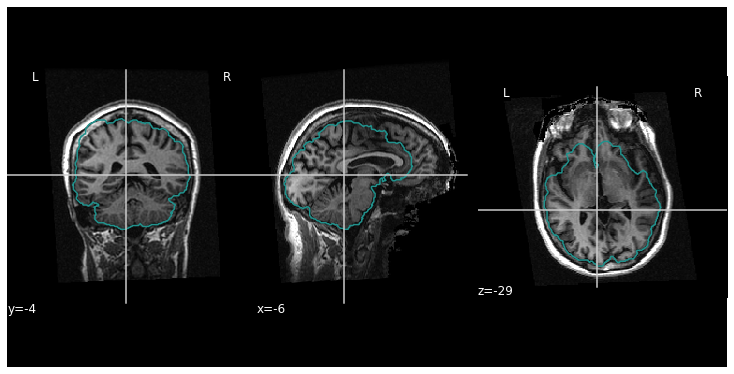

In [8]:
import matplotlib.pyplot as plt
from nilearn import plotting, image

t1_raw = f"{data_dir}/{test_subj}/ses-test/anat/{test_subj}_ses-test_T1w.nii.gz"

fig = plt.figure(figsize=(10,5))
disp_t1 = plotting.plot_anat(t1_raw, dim=-1, figure=fig)
disp_t1.add_contours(f"/output/datasink/{test_subj}_ses-test_T1w_brain_mask.nii",
                     levels=[0.5])


This doesn't look good! As you can see, too much of the frontal cortex has been removed. 

To solve this problem, we can try to tweak the parameters of ```BET```. In the example above, we applied a fractional intensity treshold of 0.6 (see the ```frac``` parameter) - let's change this to a smaller value so that we have a larger brain outline estimate. 

For testing purposes, we will run this as a single interface (i.e., we do not include it in our worklow)

In [11]:
strip_skull2 = BET(in_file=f"{data_dir}/{test_subj}/ses-test/anat/{test_subj}_ses-test_T1w.nii.gz",
                   frac=0.5, mask=True)

result_bet = strip_skull2.run()

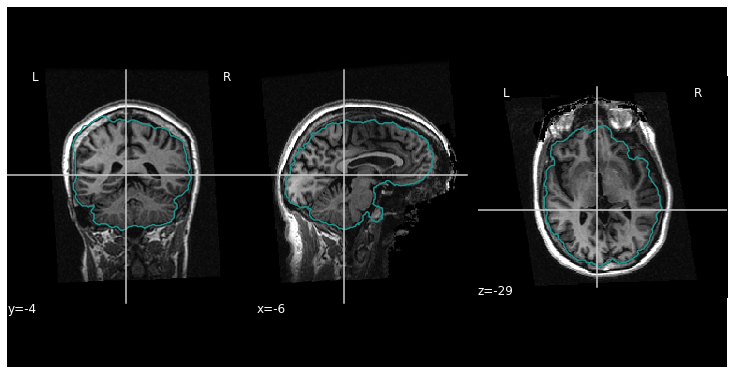

In [13]:
fig = plt.figure(figsize=(10,5))
disp_t1 = plotting.plot_anat(f"{data_dir}/{test_subj}/ses-test/anat/{test_subj}_ses-test_T1w.nii.gz",
                             dim=-1, figure=fig)
disp_t1.add_contours(result_bet.outputs.mask_file, levels=[0.5])

This looks better than before! Now, we can update the ```BET``` node in our workflow with the appropriate parameter. Note that ```BET``` comes with additional parameters that sometimes need to be tuned for specific scanner/sequences to get optimal results.

In this example, we ran the second ```BET``` as a standalone interface. However, Nipype workflows allow for iterating over different parameters of specific nodes:




In [ ]:
strip_skull = Node(BET(mask=True),
                   name="strip_skull")

frac = [0.2, 0.4, 0.6, 0.8]
strip_skull.iterables = ("frac", frac)

This was only an example. The main takeaway is that oftentimes you will need to experiment a bit to achieve optimal results. There is no one-size-fits-all approach in neuroimaging analysis!


### Example: Motion Correction

In addition to the brain extraction, our workflow also included motion correction of the functional images. As presented in the lecture, there are different options to check whether the motion correction (realignment) worked as planned.

### Option 1: Visually compare spatial layout of realigned files

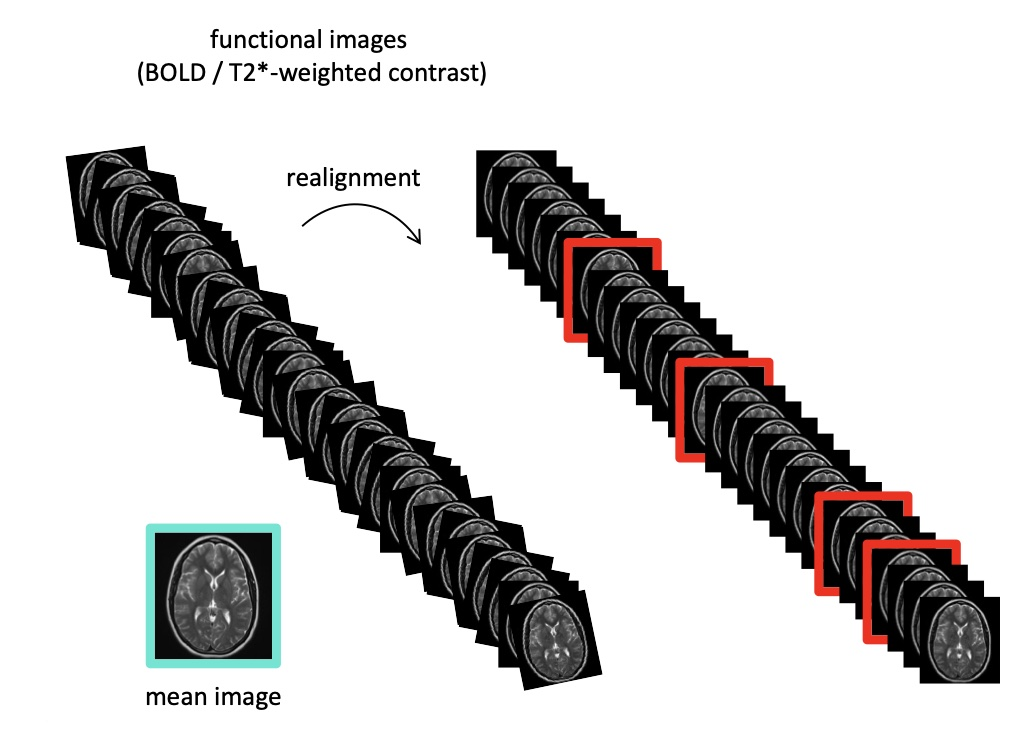

One option is to plot the mean functional image as well as some random (realigned) volumes to compare their spatial layout. For this we can use Nilearn's ```plotting``` and ```image``` modules:


/usr/local/lib/python3.7/dist-packages/nilearn/image/resampling.py:545: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/usr/local/lib/python3.7/dist-packages/nilearn/image/resampling.py:545: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/usr/local/lib/python3.7/dist-packages/nilearn/image/resampling.py:545: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/usr/local/lib/python3.7/dist-packages/nilearn/image/resampling.py:545: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


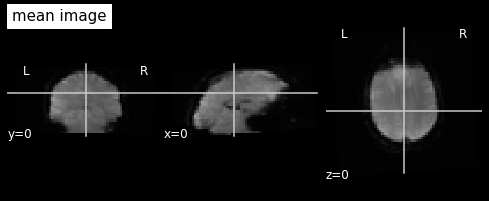

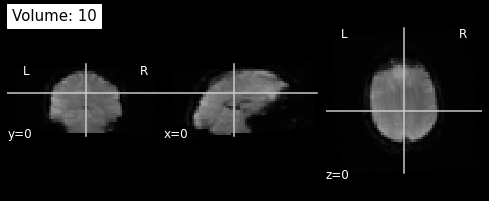

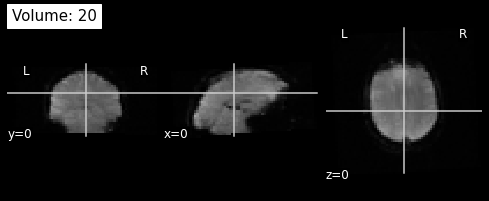

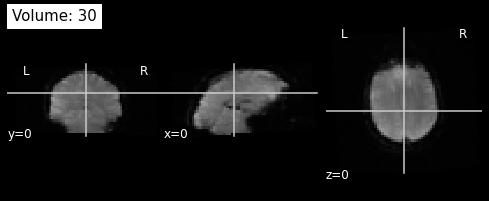

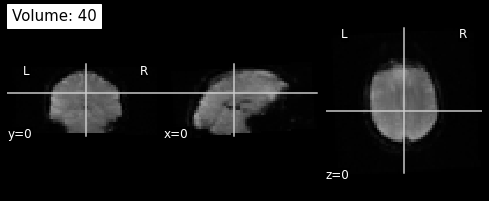

In [16]:
from nilearn import plotting, image

realigned_images = f"/output/datasink/{test_subj}_ses-test_task-covertverbgeneration_bold_roi_mcf.nii"
mean_image = f"/output/datasink/{test_subj}_ses-test_task-covertverbgeneration_bold_roi_mcf.nii_mean_reg.nii"

# mean image
plotting.plot_anat(mean_image, title="mean image",
                   cut_coords=(0,0,0),
                   draw_cross=True)
# plot random volumes
for i in range(10, 50, 10):
  plotting.plot_anat(image.index_img(realigned_images, i), title = f"Volume: {i}",
                     cut_coords=(0,0,0), draw_cross=True)


Nothing unusal here! The random functional volumes seem to be aligned with the mean functional image.

### Option 2: Plot realignment parameters

When we performed the realignment, we also told Nipype to output the motion parameters (see the ```save_plots``` parameter in FSL's ```MCFLIRT```). To recap the lecture, there are six motion parameters: 3 corresponding to translation (in x, y, z direction, respectively) and 3 corresponding to rotation (pitch, roll, yaw, respectively). We can access the estimates of these parameters for each volume by loading the ```.par``` file that the realignment procedure has created.

In [26]:
import numpy as np

motion_parameters = np.loadtxt(f"/output/datasink/{test_subj}_ses-test_task-covertverbgeneration_bold_roi_mcf.nii.par")
print(f"Shape of motion parameter matrix: {motion_parameters.shape}")
print(motion_parameters[:5, :])

Shape of motion parameter matrix: (169, 6)
[[-1.92929e-21 -4.64433e-03 -2.22430e-03 -8.12343e-02  5.04886e-01
   1.30260e-01]
 [-1.70290e-04 -4.81590e-03 -2.56256e-04  1.00650e-04  3.81968e-01
   1.24530e-01]
 [ 2.46729e-03 -4.16045e-03 -1.99065e-04  6.91490e-03  6.51105e-01
  -1.99632e-02]
 [ 1.85437e-03 -4.27622e-03  4.77894e-05  1.81509e-02  4.69172e-01
   6.21325e-02]
 [ 3.45596e-04 -4.74901e-03  1.82877e-04  3.34725e-02  2.79053e-01
   1.21129e-01]]


As expected, the ```.par``` file includes 6 columns (one for each motion parameter) and 173 rows (i.e, the number of volumes of our functional image)

Next, we will use matplotlib to visualize these parameters:

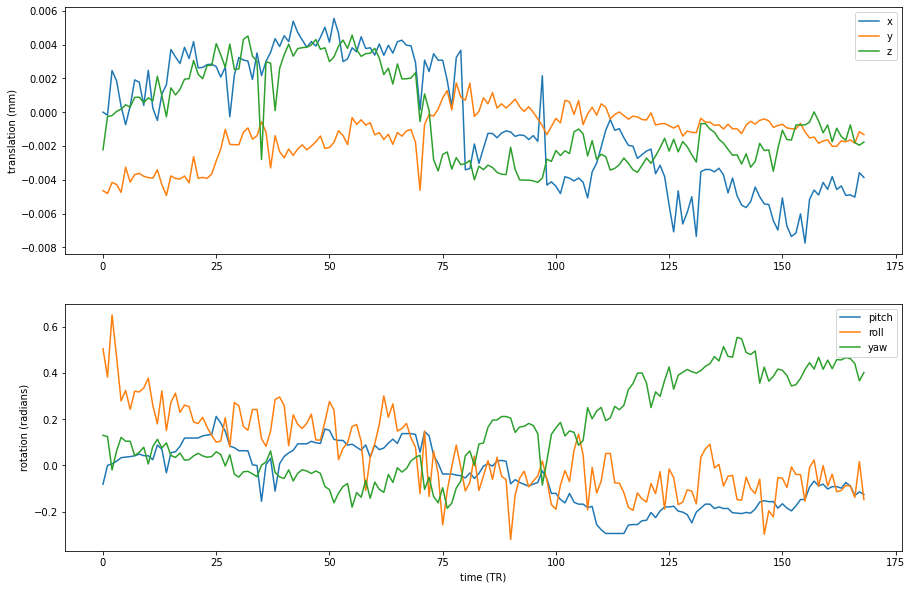

In [27]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15,10))

axes[0].plot(motion_parameters[:, :3])
axes[1].plot(motion_parameters[:, 3:])

axes[0].set_ylabel("translation (mm)")
axes[1].set_ylabel("rotation (radians)")
axes[1].set_xlabel("time (TR)")

axes[0].legend(["x","y","z"])
axes[1].legend(["pitch","roll","yaw"])

As you can see by the axes, the deviations are not too large (see for example the scale of the translation axis) and most likely no volume needs to be discarded (watch out for stimulus-correlated movement though).

## Outlook

The main purpose of this session was to give you a primer on the importance of constantly evaluating the validity of your preprocessing results (and not just at the end of the pipeline). Critically, you will often need to try out different parameter and tweak your pipeline. 

In the next session, we will have a look at analyzing fMRI data (using the general linear model). Ultimately, analzying the voxel signals allows (to some extent) for judging how good the preprocessing went. For example, if you know that a participant pressed a button with their right hand at some point in your experiment, you will need to find a BOLD signal in the left motor cortex - otherwise something went awry.

## Resources


[Debugging Nipype](https://miykael.github.io/nipype_tutorial/notebooks/basic_error_and_crashes.html): Some guidance on how to handle errors and crashes of Nipype workflows